In [1]:
pip install transformers 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch as t
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import time
import numpy as np
import sklearn
import pickle
import re

In [3]:
def create_dataset(i_start=0, i_end=50, operation=t.add): 
    """(1 pt) Create a dataset of pairs of numbers to calculate an operation
on.
   DO NOT USE A FOR LOOP. Use pytorch functions, possibilities include
meshgrid, stack, reshape, repeat, tile.
   (Note you'll have to use for loops on string stuff in other functions)
   The dataset should be a tuple of two tensors, X and y, where X is a Nx2
tensor of numbers to add,
   and y is a N tensor of the correct answers.
   E.g., if i_start=0, i_end=2, then X should be
tensor([[0,0,1,1],[0,1,0,1]]).T and y should be tensor([0,1,1,2]).
   I recommend doing all pairs of sums involving 0-49, but you may modify
this.
"""
    input_x = t.arange(i_start, i_end)
    X1, X2 = t.meshgrid(input_x, input_x)
    X1 = X1.reshape(-1)
    X2 = X2.reshape(-1)
    X = t.stack([X1, X2], dim=1)

    y = operation(X[:, 0], X[:, 1])

    return X, y 

In [4]:
def encode_problems(X, strategy='baseline'):
    """(1 pts) Encode the problems as strings. For example, if X is
[[0,0,1,1],[0,1,0,1]],
then the baseline output should be ["0+0=", "0+1=", "1+0=", "1+1="]"""
    output_strings = [] 
    len = X.shape[0]
    i = 0 
    for xi in X:       
        if strategy == 'baseline':           
            encode_string = str(xi[0].item())+ "+" + str(xi[1].item()) + "="
            output_strings.append(encode_string)
        if strategy == 'new':           
            encode_string = "1+2=3,3+2=5,"+str(xi[0].item())+ "+" + str(xi[1].item()) + "="
            output_strings.append(encode_string)  
        i+=1
#     print(output_strings) 
    return output_strings

In [5]:
def load_LLM(default="EleutherAI/gpt-neo-1.3B", device='cpu'):   
    """(1 pt) Load a pretrained LLM and put on device. Default choice is a
large-ish GPT-neo-2.7B model on Huggingface.
   Could also consider the "open GPT" from facebook: "facebook/opt-2.7b", or
others
   here: https://huggingface.co/models?pipeline_tag=text-generation
   Explicitly load model and tokenizer, don't use the huggingface "pipeline"
which hides details of the model
(and it also has no batch processing, which we need here) """
    
    tokenizer = AutoTokenizer.from_pretrained(default)
    model = AutoModelForCausalLM.from_pretrained(default).to(device)
    model.eval()
  
    return model, tokenizer

In [6]:
model, tokenizer = load_LLM("EleutherAI/gpt-neo-1.3B")

In [7]:
from sklearn.neighbors import KNeighborsClassifier

In [8]:
import torch
import time


def generate_text(model, tokenizer, prompts, verbose=True, device='cpu'):
"""(3 pts) Complete the prompt using the LLM.
1. Tokenize the prompts:
https://huggingface.co/docs/transformers/preprocessing
       Put data and model on device to speed up computations
       (Note that in real life, you'd use a dataloader to do this efficiently
in the background during training.)
   2. Generate text using the model.
       Turn off gradient tracking to save memory.
       Determine the sampling hyper-parameters.
       You may need to do it in batches, depending on memory constraints
   3. Use the tokenizer to decode the output.
   You will need to optionally print out the tokenization of the input and
output strings for use in the write-up.
"""
    t0 = time.time() 
    output_ids = []    
    # Tokenize the prompts
    tokenizer.pad_token = tokenizer.eos_token  
    input_encoded = tokenizer(prompts, padding = True, add_special_tokens= True, truncation = True, return_tensors="pt")
    input_ids = input_encoded['input_ids']
    attention_mask = input_encoded['attention_mask']
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    
    if verbose:
        print("Input tokenization example:")
        for i in range(min(len(prompts), 3)):
            print(f"\tPrompt {i}: {prompts[i]}")
            print(f"\tTokenized prompt {i}: {tokenizer.convert_ids_to_tokens(input_ids[i].tolist())}")
        print()
    
    # Generate text
    output_ids = []
    batch_size = 25
    with torch.no_grad():
        for i in range(0, len(input_ids), batch_size):
            input_batch = input_ids[i:i+batch_size]
            attention_mask_batch = attention_mask[i:i+batch_size]
            output_batch = model.generate(
                input_ids=input_batch,
                do_sample=True,
                attention_mask=attention_mask_batch,
                temperature=0.001,
                min_new_tokens = 10,
                max_new_tokens=30
            )
            output_ids.append(output_batch)
            print(i) 
    output_ids = torch.cat(output_ids, dim=0)
    
    # Decode output
    output_strings = [tokenizer.decode(output_id, skip_special_tokens=True) for output_id in output_ids]
    
    if verbose:
        print("Output tokenization example:")
        for i in range(min(len(output_strings), 3)):
            print(f"\tOutput Tokenization {i}: {output_strings[i]}")
        print()
        print("Time to generate text: ", time.time() - t0)
    
    return output_strings

In [9]:
import numpy as np

def decode_output(output_strings, strategy='baseline', verbose=True):
    """(1 pt) Decode the output strings into a list of integers. Use "t.nan"
for failed responses.
   One suggestion is to split on non-numeric characters, then convert to int.
And use try/except to catch errors.
   """
    y_hat = []
    for s in output_strings:       
        if strategy == 'baseline':         
            if len(s)>=1:
                if s[0].isdigit() and s[1].isdigit():
                    val = s[0]+s[1]
                elif s[0].isdigit() and s[1].isdigit()==False:
                    val = s[0]
                else:
                    val = np.nan
            else:
                val = np.nan
            
        elif strategy == 'new':          
            c = s.split(",")[0]
            if c.isdigit() == True:
                val = c
            else: 
                val = np.nan
        y_hat.append(val)
      
    if verbose:
        print("Output decoding example:")
        for i in range(min(len(output_strings), 3)):
            print(f"\tGenerated text {i}: {output_strings[i]}")
            print(f"\tDecoded output {i}: {y_hat[i]}")
        print()
    
    return y_hat

In [10]:
def analyze_results(X, y, y_hats, strategy):
    """(3 pts) Analyze the results.
Output the accuracy of each strategy.
Plot a scatter plot of the problems “x1+x2” with x1,x2 on each axis,
and different plot markers to indicate whether the answer from your LLM was
correct.
   (See write-up instructions for requirements on plots)
   Train a classifier to predict whether the LLM gave the correct response
(using scikit-learn, for example)
   and plot the classifier boundary over the scatter plot with “contour”. (Use
whatever classifier looks appropriate)"""
    
    count = 0
    y_binary = []
    legend_drawn = False
    for i in range(len(y)):
        f = float(y_hats[i])
        if np.isnan(f):
            y_binary.append(0)
            continue
        if y_hats[i].isdigit() and int(y_hats[i]) == y[i].item():
            count+= 1
            y_binary.append(1)
        else:
            y_binary.append(0)
    print("Count : ", count)
    print("Accuracy : ", count*100/2500)
        
          
    fig, ax = plt.subplots()
    markers = {True: {'marker': 'x', 'label': 'InCorrect'}, False: {'marker': 'o', 'label': 'Correct'}}
    for i in range(len(y)):
        marker = markers[y_binary[i]==0]
        ax.scatter(X[i][0], X[i][1], marker = marker['marker'], color='black', label=marker['label'])
        if not legend_drawn:
            ax.legend()
            legend_drawn = True

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title(strategy)

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X, y_binary)

    #Plotting the decision boundary 
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='red', levels=[0.5], linestyles='dashed')
    plt.show()

/Users/niyathiallu/opt/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


cpu
new
Input tokenization example:
	Prompt 0: 1+2=3,3+2=5,0+0=
	Tokenized prompt 0: ['1', '+', '2', '=', '3', ',', '3', '+', '2', '=', '5', ',', '0', '+', '0', '=']
	Prompt 1: 1+2=3,3+2=5,0+1=
	Tokenized prompt 1: ['1', '+', '2', '=', '3', ',', '3', '+', '2', '=', '5', ',', '0', '+', '1', '=']
	Prompt 2: 1+2=3,3+2=5,0+2=
	Tokenized prompt 2: ['1', '+', '2', '=', '3', ',', '3', '+', '2', '=', '5', ',', '0', '+', '2', '=']



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


25


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


75


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


125


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


150


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


175


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


200


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


225


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


250


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


275


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


300


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


325


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


350


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


375


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


400


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


425


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


450


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


475


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


500


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


525


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


550


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


575


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


600


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


625


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


650


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


675


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


700


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


725


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


750


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


775


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


800


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


825


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


850


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


875


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


900


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


925


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


950


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


975


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1000


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1025


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1050


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1075


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1125


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1150


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1175


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1200


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1225


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1250


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1275


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1300


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1325


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1350


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1375


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1400


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1425


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1450


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1475


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1500


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1525


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1550


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1575


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1600


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1625


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1650


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1675


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1700


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1725


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1750


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1775


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1800


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1825


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1850


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1875


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1900


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1925


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1950


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1975


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2000


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2025


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2050


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2075


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2125


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2150


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2175


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2200


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2225


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2250


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2275


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2300


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2325


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2350


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2375


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2400


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2425


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2450
2475
Time to generate text:  4008.925586938858
Output decoding example:
	Generated text 0: 0,1+1=1,1+2=2,2+2=3,3+3=5,4+4=
	Decoded output 0: 0
	Generated text 1: 1,1+1=2,1+2=3,1+3=5,1+4=7,1+5=
	Decoded output 1: 1
	Generated text 2: 3,0+3=5,0+4=3,0+5=5,0+6=3,0+7=
	Decoded output 2: 3

FewShot Learning
Count :  248
Accuracy :  9.92


/Users/niyathiallu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


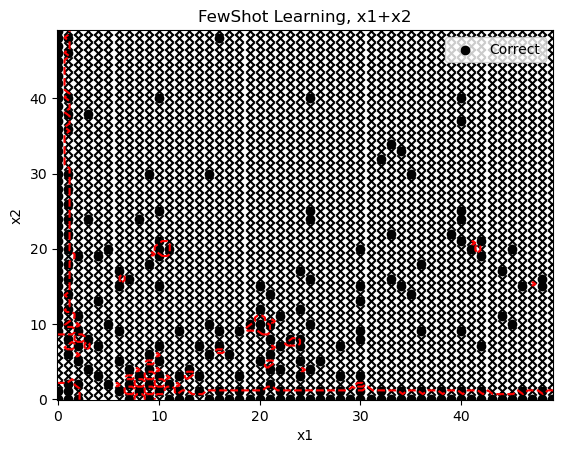

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


baseline
Input tokenization example:
	Prompt 0: 0+0=
	Tokenized prompt 0: ['0', '+', '0', '=']
	Prompt 1: 0+1=
	Tokenized prompt 1: ['0', '+', '1', '=']
	Prompt 2: 0+2=
	Tokenized prompt 2: ['0', '+', '2', '=']



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


25


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


75


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


125


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


150


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


175


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


200


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


225


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


250


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


275


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


300


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


325


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


350


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


375


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


400


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


425


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


450


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


475


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


500


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


525


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


550


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


575


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


600


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


625


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


650


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


675


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


700


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


725


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


750


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


775


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


800


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


825


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


850


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


875


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


900


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


925


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


950


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


975


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1000


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1025


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1050


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1075


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1125


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1150


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1175


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1200


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1225


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1250


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1275


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1300


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1325


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1350


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1375


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1400


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1425


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1450


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1475


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1500


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1525


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1550


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1575


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1600


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1625


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1650


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1675


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1700


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1725


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1750


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1775


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1800


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1825


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1850


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1875


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1900


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1925


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1950


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1975


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2000


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2025


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2050


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2075


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2125


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2150


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2175


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2200


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2225


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2250


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2275


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2300


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2325


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2350


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2375


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2400


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2425


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2450
2475
Time to generate text:  3763.481908798218
Output decoding example:
	Generated text 0: 0+0=0+0=0+0=0+0=0+0=0+0=0+0=0+
	Decoded output 0: 0
	Generated text 1: 0$ and $0+1=1$.

The following lemma is a direct consequence of the definition of the $n$-th
	Decoded output 1: 0
	Generated text 2: 0+2=0+2=0+2=0+2=0+2=0+2=0+2=0+
	Decoded output 2: 0

Baseline
Count :  24
Accuracy :  0.96


/Users/niyathiallu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


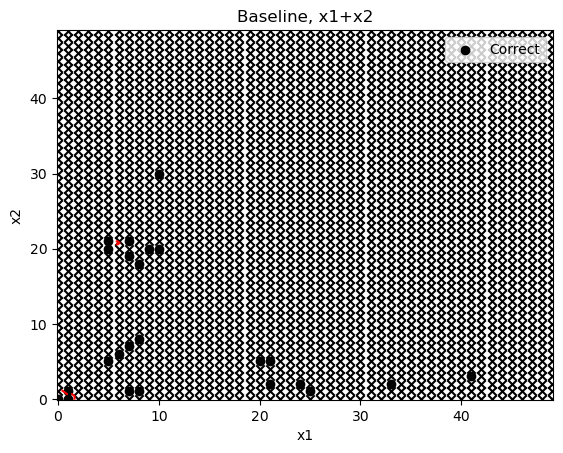

In [11]:
if __name__ == "__main__":
    device = "cpu"
#     device = t.device("cuda" if t.cuda.is_available() else "cpu")

#     device = t.device('mps') if t.backends.mps.is_available() else device
    X, y = create_dataset(0, 50)
    print(device)
#     model, tokenizer = load_LLM("EleutherAI/gpt-neo-1.3B")
    model.resize_token_embeddings(len(tokenizer))
 
    model.eval()
    y_hats = []
    strategies = ['new', 'baseline']
    for strategy in strategies:
        print(strategy)
        input_strings = encode_problems(X, strategy=strategy)
        output_strings = generate_text(model, tokenizer, input_strings, device=device)
        output_strings = [out_s[len(in_s):] for in_s, out_s in zip(input_strings, output_strings)]
        # Remove the input string from generated answer
        y_hats = decode_output(output_strings, strategy=strategy)
        if strategy == 'new':
            strategy = "FewShot Learning"
        else: 
            strategy = "Baseline"
        print(strategy)
        analyze_results(X, y, y_hats, strategy+", x1+x2") 

In [ ]:
References :
https://chat.openai.com/?model=text-davinci-002-render 
https://towardsdatascience.com/how-to-fine-tune-gpt-2-for-text-generation-ae2ea53bc272 
https://www.youtube.com/watch?v=elUCn_TFdQc&t=1460s 

model

In [14]:
model

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 2048)
    (wpe): Embedding(2048, 2048)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (out_proj): Linear(in_features=2048, out_features=2048, bias=True)
          )
        )
        (ln_2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=2048, out_features=8192, bias=True)
          (c_proj): Linear(

In [17]:
def infer(input):  
    input = tokenizer(input, return_tensors = "pt")
    X = input["input_ids"].to(device)
    a = input["attention_mask"].to(device)
    output = model.generate(X, attention_mask = a, do_sample = False, max_length = 50, temperature = 0.001)
    output_float = output[0].float()
    probs = torch.softmax(output_float, dim=-1).tolist()
    output_str = tokenizer.decode(output[0]) 

    return output_str, probs, output[0]

In [54]:
output_str, probs, output = infer("1+2,3+4=5,((10/5)+(2*3)=")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [55]:
output_str

'1+2,3+4=5,((10/5)+(2*3)=6)\n\nA:\n\nYou can use the following code:\n#include <stdio.h>\n\nint main(void'

In [57]:
output_str, probs, output = infer("((10/5)+(2*3)")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [58]:
output_str

'((10/5)+(2*3)+(2*4))\n\n(10/5)+(2*3)+(2*4)\n\n(10/5)+(2*3)+(2*4)\n'